In [41]:
import pandas as pd
import numpy as np
import re
import sys, getopt, os
import csv
import pickle
import copy

pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

%run SodaKick_download_functions.ipynb

In [42]:
#note xgboost can handle missing values internally
#list of parameters:
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://shengyg.github.io/repository/machine%20learning/2017/02/25/Complete-Guide-to-Parameter-Tuning-xgboost.html

#custom obj functions
#https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
#https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

In [43]:
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.multioutput import MultiOutputRegressor

import xgboost as xgb
from xgboost import XGBRegressor

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from functools import partial 
from ray.tune.suggest.hyperopt import HyperOptSearch

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
#https://docs.ray.io/en/master/tune/tutorials/tune-xgboost.html

from hyperopt import hp

In [44]:
#https://towardsdatascience.com/quirky-keras-custom-and-asymmetric-loss-functions-for-keras-in-r-a8b5271171fe
def WSE(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      b*torch.maximum(torch.zeros(output.shape[1]),output - target)**2)      
    return loss

def WSEl1(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.abs(torch.minimum(torch.zeros(output.shape[1]),output - target))+\
                      b*torch.abs(torch.maximum(torch.zeros(output.shape[1]),output - target)))      
    return loss

def WSE2(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.minimum(np.zeros(output.shape[0]),output - target)**2+\
                      b*np.maximum(np.zeros(output.shape[0]),output - target)**2)      
    return loss

def WSEl12(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.abs(np.minimum(np.zeros(output.shape[0]),output - target))+\
                      b*np.abs(np.maximum(np.zeros(output.shape[0]),output - target)))      
    return loss

In [45]:
from sklearn import preprocessing

    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2a.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2a.pkl', 'rb') as pk:
    out=pickle.load(pk)     
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2b.pkl', 'rb') as pk:
    inpb=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2b.pkl', 'rb') as pk:
    outb=pickle.load(pk)     

inp=np.concatenate([inp,inpb])
out=np.concatenate([out,outb])

def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NormalizeMatrix(data):   
    for i in range(data.shape[1]):
        data[:,i] = NormalizeData(data[:,i])
        
NormalizeMatrix(inp)
np.nan_to_num(inp, copy=False)

normalize_mins(out)

#scaler = preprocessing.StandardScaler().fit(inp)
#inp = scaler.transform(inp)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [46]:
from typing import Tuple

def WSE(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    
    target = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    
    a=1.5
    b=.5
    
    elements = a*np.minimum(np.zeros(len(predt)),predt - target)**2+\
                      b*np.maximum(np.zeros(len(predt)),predt - target)**2
    
    return 'WSE', float(np.sqrt(np.sum(elements) / len(target)))

In [47]:
search_space = {
 "n_estimators": 50,
 "max_depth": hp.choice("max_depth",np.linspace(8,15,8, dtype=int)),
 #"max_depth": hp.choice("max_depth",np.linspace(1,15,8, dtype=int)),
 "min_child_weight": hp.choice("min_child_weight",[1, 2, 3, 4, 5]),
 "subsample": hp.choice("subsample",np.linspace(.6,.9,4)),
 #"subsample": hp.choice("subsample",np.linspace(.5,.9,5)),
 "eta": hp.choice("eta",[1e-2, 5e-2, 1e-1, 5e-1, 3e-1]),
 "colsample_bytree": hp.choice("colsample_bytree",np.linspace(0.1,.9,5)),
 "alpha": hp.randint("alpha", 3),
 #"alpha": hp.randint("alpha", 5),
 "lambda": hp.choice("lambda", np.linspace(0,10,6)),
 #"gamma": hp.choice("gamma",np.linspace(0,.9,4)),
 "objective": "reg:pseudohubererror",
 "eval_metric": "rmse", 
 "learning_rate": 1e-1, 
 }

x_train, x_test, y_train, y_test = train_test_split(
     inp, out, test_size=0.3, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(
     x_train, y_train, test_size=0.3, shuffle=True)

def train_xgb(config, col=0):
    
    evals=[]
    models=[]
    for k in range(50):
        models.append(XGBRegressor(**config))
        eval_set = [(x_train, y_train[:,col+8*k]),(x_test, y_test[:,col+8*k])]
        models[-1].fit(x_train, y_train[:,col+8*k], eval_metric="rmse", eval_set=eval_set, early_stopping_rounds = 3, verbose=False)    
        evals_result = models[-1].evals_result()   
        evals.append(evals_result['validation_1']['rmse'][-1]**2)
    
    #preds = model.predict(x_test,ntree_limit=model.get_booster().best_ntree_limit)    
    tune.report(rmse = np.sqrt(np.mean(evals)), done=True)    

def tune_xgb(search_space, col):
    
    search_alg = HyperOptSearch(space=search_space, metric="rmse", mode="min")

    # This will enable aggressive early stopping of bad trials.
    #scheduler = ASHAScheduler(
    #    max_t=20,  # 10 training iterations
    #    grace_period=5,
    #    reduction_factor=2)

    analysis = tune.run(
        partial(train_xgb, col=col),
        search_alg=search_alg,
        resources_per_trial={"cpu": 1},
        num_samples=25,
        #scheduler=scheduler,
        verbose=0,
        metric="rmse", mode="min")

    return analysis

In [23]:
#best_bst=[]
best_cfg=[]
for i in range(8):
    print('Feature #: '+str(i))
    analysis = tune_xgb(search_space, i)
    print(analysis)
    best_cfg.append(analysis.get_best_config())
    #best_cfg[-1]['file']=analysis.best_checkpoint
    #best_bst.append(get_best_model_checkpoint(analysis))
    print('\n')

2021-06-02 12:46:22,664	WARNING experiment.py:294 -- No name detected on trainable. Using DEFAULT.
2021-06-02 12:46:22,665	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.


Feature #: 0


2021-06-02 12:46:23,803	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 59262864 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
(pid=8646) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=8646)   "because it will generate extra copies and increase " +
2021-06-02 12:46:27,051	WARNING util.py:162 -- The `start_trial` operation took 0.567 s, which may be a performance bottleneck.
(pid=8834) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=8834)   "because it will generate extra copies and increase " +
2021-06-02 12:46:28,170	WARNING util.py:162 -- The `start_tri



Feature #: 1


2021-06-02 14:23:46,176	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 59262864 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-02 14:23:46,246	WARNING util.py:162 -- The `start_trial` operation took 0.502 s, which may be a performance bottleneck.
(pid=9963) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=9963)   "because it will generate extra copies and increase " +
2021-06-02 14:23:49,132	WARNING util.py:162 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.
(pid=9967) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(p



Feature #: 2


2021-06-02 15:34:17,672	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 59262864 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
(pid=10978) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=10978)   "because it will generate extra copies and increase " +
2021-06-02 15:34:20,433	WARNING util.py:162 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.
(pid=10981) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=10981)   "because it will generate extra copies and increase " +
2021-06-02 15:34:22,016	WARNING util.py:162 -- The `start



Feature #: 3


2021-06-02 16:50:26,034	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 59262864 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-02 16:50:26,149	WARNING util.py:162 -- The `start_trial` operation took 0.758 s, which may be a performance bottleneck.
2021-06-02 16:50:28,298	WARNING util.py:162 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.
(pid=12331) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=12331)   "because it will generate extra copies and increase " +
2021-06-02 16:50:30,821	WARNING util.py:162 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.
(pid=12334) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning:



Feature #: 4


2021-06-02 18:28:12,625	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 59262864 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
(pid=13139) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=13139)   "because it will generate extra copies and increase " +
(pid=13236) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=13236)   "because it will generate extra copies and increase " +
2021-06-02 18:28:17,001	WARNING util.py:162 -- The `start_trial` operation took 0.619 s, which may be a performance bottleneck.
(pid=13239) //miniconda3/lib/python3.7/site-packages/xgbo



Feature #: 5


2021-06-02 19:11:03,916	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 59262864 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-02 19:11:03,995	WARNING util.py:162 -- The `start_trial` operation took 0.503 s, which may be a performance bottleneck.
(pid=13765) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=13765)   "because it will generate extra copies and increase " +
(pid=13773) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=13773)   "because it will generate extra copies and increase " +
2021-06-02 19:11:08,097	WARNING util.py:162 -- The `start



Feature #: 6


2021-06-02 19:44:39,267	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 59262864 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
(pid=14125) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=14125)   "because it will generate extra copies and increase " +
(pid=14128) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=14128)   "because it will generate extra copies and increase " +
(pid=14131) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies an



Feature #: 7


2021-06-02 20:07:14,188	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 59262864 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
(pid=14509) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=14509)   "because it will generate extra copies and increase " +
(pid=14516) //miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
(pid=14516)   "because it will generate extra copies and increase " +
2021-06-02 20:07:18,185	WARNING util.py:162 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.
(pid=14519) //miniconda3/lib/python3.7/site-packages/xgbo

In [11]:
stats=pd.concat([pd.Series(bc) for bc in best_cfg], axis=1).T
stats

,alpha,colsample_bytree,eta,eval_metric,gamma,lambda,learning_rate,max_depth,min_child_weight,n_estimators,objective,subsample
0,1,0.3,0.3,rmse,0.0,0.0,0.1,13,1,203,reg:pseudohubererror,0.9
1,2,0.5,0.5,rmse,0.0,10.0,0.1,13,2,107,reg:pseudohubererror,0.8
2,1,0.9,0.05,rmse,0.0,0.0,0.1,13,2,216,reg:pseudohubererror,0.8
3,0,0.7,0.3,rmse,0.0,8.0,0.1,9,3,452,reg:pseudohubererror,0.9
4,0,0.9,0.05,rmse,0.0,6.0,0.1,11,5,386,reg:pseudohubererror,0.8
5,2,0.9,0.05,rmse,0.0,0.0,0.1,9,4,211,reg:pseudohubererror,0.7
6,3,0.3,0.05,rmse,0.0,4.0,0.1,13,4,425,reg:pseudohubererror,0.9
7,1,0.1,0.5,rmse,0.0,6.0,0.1,13,1,419,reg:pseudohubererror,0.8


In [49]:
#with open(r'/Users/federico comitani/GitHub/sodakick/data/best_cfg.pkl', 'wb') as file:
#    pickle.dump(best_cfg,file)

In [50]:
with open(r'/Users/federico comitani/GitHub/sodakick/data/best_cfg.pkl', 'rb') as file:
    best_cfg=pickle.load(file)

In [63]:
for i in range(len(best_cfg)):
    best_cfg[i]['eta']=.3
    best_cfg[i]['max_depth']=7
    best_cfg[i]['subsample']=.8  
    best_cfg[i]['min_child_weight']=1  
    best_cfg[i]['alpha']=10
    best_cfg[i]['lambda']=1

# K fold on single column because why not

In [26]:
from sklearn.model_selection import KFold

def runKfold(indata, outdata, num, best_cfg=best_cfg):
    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(indata)
    
    tmpparms = best_cfg[num]
    tmpparms.pop("file", None)    
    tmpparms['n_estimators']=1000
    print(tmpparms)
        
    ec,losses, errors = [], [], []
    rmses = []
    results=[]
    
    for train_index, test_index in kf.split(indata):        
        x_train, y_train, x_test, y_test = indata[train_index], outdata[train_index], indata[test_index], outdata[test_index]

        train_set = xgb.DMatrix(x_train, label=y_train[:,i])
        test_set = xgb.DMatrix(x_test, label=y_test[:,i])
    
        model=XGBRegressor(**tmpparms)
        model.fit(x_train, y_train[:,i],
            eval_set = [(x_train, y_train[:,i]),(x_test, y_test[:,i])],
            eval_metric = 'rmse',
            early_stopping_rounds = 10, verbose=False)
        
        results.append(model.evals_result())
        best_iteration = model.get_booster().best_ntree_limit
        
        #pred = model.predict(x_test, ntree_limit=best_iteration)
        #errors.append(np.mean(pred-y_test[:,i]))

        ec.append(model.best_iteration)
        losses.append(model.get_booster().best_score)
        #rmses.append(results[-1]['validation_1']['rmse'][-1])
    
    print('Num: {:.3f}+/-{:.3f}'.format(np.mean(ec),np.std(ec)))
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    #print('Error Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in errors]),np.std([np.mean(x) for x in errors])))
    #print('RMSE Result: {:.3f}+/-{:.3f}'.format(np.mean(rmses),np.std(rmses)))

    # plot log loss
    fig, ax = plt.subplots()
    for rs in results:
        ax.plot(range(len(rs['validation_0']['rmse'])), rs['validation_0']['rmse'], label='Train', color='blue')
        ax.plot(range(len(rs['validation_1']['rmse'])), rs['validation_1']['rmse'], label='Test', color='orange')
    plt.show()
    
    return np.mean([np.mean(x) for x in losses]), np.mean(ec)

Feature #: 0
{'alpha': 1, 'colsample_bytree': 0.30000000000000004, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 0.0, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}
Num: 288.000+/-162.920
KFold Result: 0.505+/-0.952


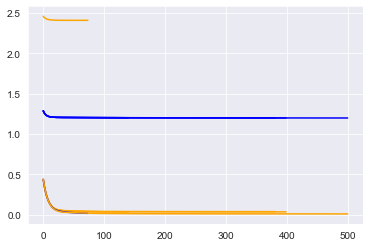


Feature #: 1
{'alpha': 2, 'colsample_bytree': 0.5, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 10.0, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 2, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}
Num: 102.000+/-16.334
KFold Result: 0.013+/-0.010


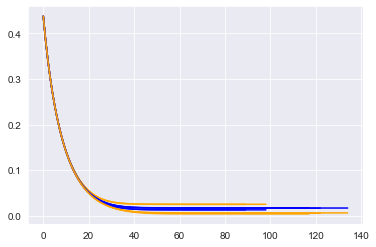


Feature #: 2
{'alpha': 1, 'colsample_bytree': 0.9, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 0.0, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 2, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}
Num: 179.400+/-39.215
KFold Result: 0.030+/-0.014


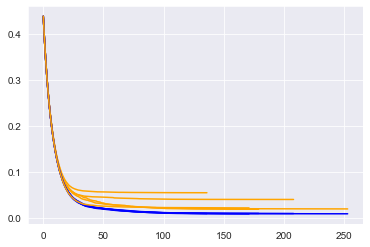


Feature #: 3
{'alpha': 0, 'colsample_bytree': 0.7000000000000001, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 8.0, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 3, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}
Num: 432.600+/-70.420
KFold Result: 0.071+/-0.018


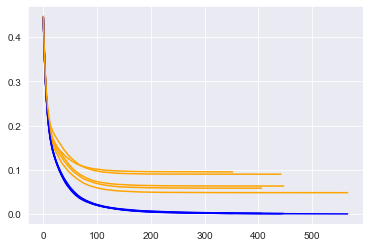


Feature #: 4
{'alpha': 0, 'colsample_bytree': 0.9, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 6.0, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}
Num: 587.200+/-314.731
KFold Result: 0.007+/-0.003


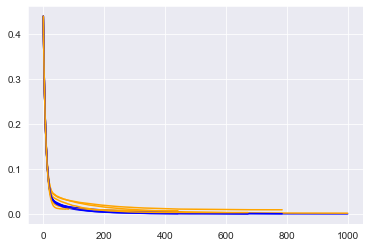


Feature #: 5
{'alpha': 2, 'colsample_bytree': 0.9, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 0.0, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}
Num: 140.800+/-12.812
KFold Result: 0.027+/-0.008


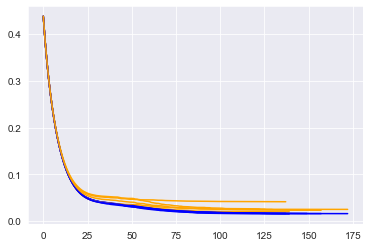


Feature #: 6
{'alpha': 3, 'colsample_bytree': 0.30000000000000004, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 4.0, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}
Num: 539.600+/-79.177
KFold Result: 0.514+/-0.045


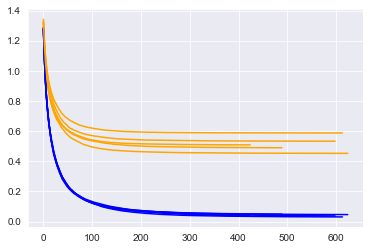


Feature #: 7
{'alpha': 1, 'colsample_bytree': 0.1, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 6.0, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}
Num: 394.200+/-61.421
KFold Result: 0.792+/-0.035


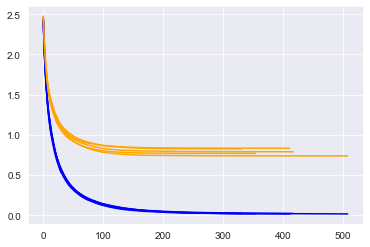


[288.0, 102.0, 179.4, 432.6, 587.2, 140.8, 539.6, 394.2]


In [28]:
rmses, epochss=[],[]
for i in range(8):
    print('Feature #: '+str(i))
    rmse, epochs = runKfold(inp, out, i, best_cfg)
    rmses.append(rmse)
    epochss.append(epochs)
    print()
    
print(epochss)

# Now train as multioutput

In [64]:
from sklearn.multioutput import MultiOutputRegressor

x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.20, random_state=32)

models=[]
for num in range(8):
    
    tmpparms = best_cfg[num]
    tmpparms.pop("file", None)    
    tmpparms['n_estimators']=tmpparms['n_estimators']
    print(tmpparms)
    
    models.append(MultiOutputRegressor(
        XGBRegressor(**tmpparms)))
    models[-1].fit(x_train, y_train[:,num::8])

{'alpha': 10, 'colsample_bytree': 0.30000000000000004, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 203, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 10, 'colsample_bytree': 0.5, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 107, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 10, 'colsample_bytree': 0.9, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 216, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 10, 'colsample_bytree': 0.7000000000000001, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 452, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 10, 'colsample_bytree': 0.9, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 386, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 10, 'colsample_bytree': 0.9, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 211, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 10, 'colsample_bytree': 0.30000000000000004, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 425, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'alpha': 10, 'colsample_bytree': 0.1, 'eta': 0.3, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 419, 'objective': 'reg:pseudohubererror', 'subsample': 0.8}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [65]:
def multiprediction(inpt, models):
    
    preds=[]
    for model in models:
        preds.append(model.predict(inpt))
        
    preds = np.array(preds)   
    preds = np.resize(preds, (preds.shape[1], preds.shape[2]*preds.shape[0]))
    
    rearranged=[]
    
    for j in range(50):
        for i in range(8):
            rearranged.append(j+50*i)
        
    return preds[:,rearranged]

In [66]:
y_pred = multiprediction(x_test, models)

In [67]:
from sklearn.metrics import mean_squared_error as mse
mse(y_pred,y_test)

0.21242410021908678

# Manual inspection

In [68]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*y_test[0].shape[0]),y_test[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*y_test[0].shape[0]),y_test[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*y_test[0].shape[0]),y_test[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*y_test[0].shape[0]),y_test[0], a=1, b=1)))

print((y_test[1]-y_test[10]).sum())
print((y_test[50]-y_test[60]).sum())
print((y_test[100]-y_test[110]).sum())

Baseline WSE: 0.169
Baseline WSE l1: 0.139
Baseline MSE: 0.113
Baseline MSE l1: 0.092
-8.588888888888889
-11.033333333333333
7.0


In [69]:
print('Baseline WSE: {:.3f}'.format(WSE2(y_pred[0],y_test[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(y_pred[0],y_test[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(y_pred[0],y_test[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(y_pred[0],y_test[0], a=1, b=1)))

print((y_pred[1]-y_pred[10]).sum())
print((y_pred[50]-y_pred[60]).sum())
print((y_pred[100]-y_pred[110]).sum())

Baseline WSE: 0.187
Baseline WSE l1: 0.209
Baseline MSE: 0.337
Baseline MSE l1: 0.384
-0.11746752
0.36883962
1.4857566


In [70]:
import copy

def revert_output(output,lineup=None):

    
    reframe=pd.DataFrame(copy.deepcopy(output.reshape(50,8)),
                 columns=['minutes','goals','assists','cards_yellow','cards_red','own_goals','goals_against','saves'])
    
    reframe[reframe<0] = 0
    if lineup is not None:
        reframe.index=lineup
        reframe.drop([x for x in reframe.index if x.startswith('dummy')], axis=0, inplace=True)
        
    reframe['minutes']*=90
    #byteamframe=pd.concat([reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==0].index]].sum(axis=0),
    #                    reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==1].index]].sum(axis=0)], axis=1).T
    
    byteamframe=pd.concat([reframe.iloc[:25,:].sum(axis=0),reframe.iloc[25:,:].sum(axis=0)], axis=1).T
    
    return reframe, byteamframe[byteamframe.columns[1:]]

In [71]:
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(y_pred[0])
print(byteamframe)
reframe, byteamframe = revert_output(y_test[0])
print(byteamframe)

       goals    assists  cards_yellow  cards_red  own_goals  goals_against  \
0  10.921752  11.043104     11.077677  10.964314  11.019416      11.097224   
1  10.874120  11.123233     11.256147  11.326427  11.050555      11.042955   

       saves  
0  10.866703  
1  11.128687  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    0.0      0.0           3.0        0.0        0.0            3.0    1.0
1    3.0      3.0           1.0        0.0        0.0            0.0    1.0


In [72]:
y_pred[0,1::8]

array([ 1.0000896e+00,  8.9333844e-01,  8.8945526e-01,  9.0025336e-01,
        1.0031434e+00,  8.9072794e-01,  8.7140775e-01,  9.3804651e-01,
        9.1663307e-01,  8.4534824e-01,  6.8123728e-01, -7.9491478e-04,
        5.2670389e-02,  1.4518897e-02,  1.0114768e-01,  1.5788506e-01,
        1.6098389e-01,  1.4159755e-01,  1.8785018e-01,  9.1954067e-02,
        3.9437123e-02,  1.3354431e-02,  1.2612462e-01,  2.2743258e-03,
        2.2733016e-03,  9.9712580e-01,  9.2850870e-01,  9.7643578e-01,
        9.2680788e-01,  8.5924488e-01,  9.4994617e-01,  9.0787619e-01,
        9.9203432e-01,  9.2010409e-01,  8.9763874e-01,  8.5499990e-01,
        6.3629947e-03, -1.3527263e-02, -2.7080251e-02,  1.3987884e-01,
        2.0184037e-01,  7.4870273e-02,  7.2397135e-02,  4.6055462e-02,
        6.5094031e-02,  3.2127894e-02,  9.9415323e-03,  1.0281648e-02,
        2.2733016e-03,  2.2733016e-03], dtype=float32)

In [73]:
y_test[0,0::8]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.78888889, 0.66666667, 1.        , 0.66666667, 1.        ,
       1.        , 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 0.33333333, 0.21111111, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.94444444, 1.        , 0.85555556,
       0.75555556, 0.        , 0.        , 0.        , 0.05555556,
       0.24444444, 0.14444444, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

# Common hyperparameters

In [9]:
{"objective":"reg:pseudohubererror", 'colsample_bytree': 0.3, 'learning_rate': 0.1,
                'max_depth': 7, 'alpha': 10, 'eta' : 0.3, 'gamma' : 0, 'lambda' : 1, 
          'n_estimators' : 1000}

best_cfg[0]

{'alpha': 1,
 'colsample_bytree': 0.30000000000000004,
 'eta': 0.3,
 'eval_metric': 'rmse',
 'gamma': 0.0,
 'lambda': 0.0,
 'learning_rate': 0.1,
 'max_depth': 13,
 'min_child_weight': 1,
 'n_estimators': 203,
 'objective': 'reg:pseudohubererror',
 'subsample': 0.9}

In [74]:
x_train, x_test, y_train, y_test = train_test_split(
     inp, out, test_size=0.6, shuffle=True)

In [75]:
tmpparms = best_cfg[0]
tmpparms['n_estimators']=int(200)

model = MultiOutputRegressor(
    XGBRegressor(**tmpparms))

model.fit(x_train, y_train)

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


MultiOutputRegressor(estimator=XGBRegressor(alpha=10, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.30000000000000004,
                                            eta=0.3, eval_metric='rmse',
                                            gamma=0.0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            lambda=1, learning_rate=0.1,
                                            max_delta_step=None, max_depth=7,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=Non

In [76]:
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error as mse
mse(y_pred,y_test)

0.03439678808794402

In [77]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*y_train[0].shape[0]),y_train[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*y_train[0].shape[0]),y_train[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*y_train[0].shape[0]),y_train[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*y_train[0].shape[0]),y_train[0], a=1, b=1)))

print((y_train[1]-y_train[10]).sum())
print((y_train[50]-y_train[60]).sum())
print((y_train[100]-y_train[110]).sum())

print('Baseline WSE: {:.3f}'.format(WSE2(y_pred[0],y_train[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(y_pred[0],y_train[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(y_pred[0],y_train[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(y_pred[0],y_train[0], a=1, b=1)))

print((y_pred[1]-y_pred[10]).sum())
print((y_pred[50]-y_pred[60]).sum())
print((y_pred[100]-y_pred[110]).sum())

Baseline WSE: 0.125
Baseline WSE l1: 0.116
Baseline MSE: 0.083
Baseline MSE l1: 0.077
-2.0
-7.0
6.0
Baseline WSE: 0.035
Baseline WSE l1: 0.045
Baseline MSE: 0.049
Baseline MSE l1: 0.057
2.010324
-4.087251
-1.0844393


In [78]:
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(y_pred[0])
print(byteamframe)
reframe, byteamframe = revert_output(out[0])
print(byteamframe)

     goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.65255  1.001041      1.970946   0.137854   0.130410       1.230570   
1  0.94957  0.790622      1.641595   0.451127   0.162275       1.631428   

      saves  
0  2.202269  
1  5.393754  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    1.0      1.0           3.0        0.0        0.0            0.0    3.0
1    0.0      0.0           1.0        0.0        0.0            1.0    5.0
